In [ ]:
!pip install pandas numpy prophet requests earthaccess xarray matplotlib openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 137.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.5.0
    Uninstalling tenacity-8.5.0:
      Successfully uninstalled tenacity-8.5.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.9.0 which

In [ ]:
# ============================================================
# 🇲🇽 TEMPO NO₂ L3 — Descarga masiva y dataset nacional
# ============================================================
import earthaccess, xarray as xr, pandas as pd, numpy as np, os, time

# 🔹 Autenticación NASA
auth = earthaccess.login()

# ============================================================
# 1️⃣ Parámetros de búsqueda
# ============================================================
# Cobertura completa de México
BBOX_MEXICO = (-118, 14, -86, 33)  # minlon, minlat, maxlon, maxlat
DATES = ("2025-09-13", "2025-09-16")  # tres días continuos (ajusta según tiempo disponible)
MAX_GRANULES = 50  # 🔥 puedes subirlo hasta 100 si quieres full

# ============================================================
# 2️⃣ Buscar y descargar en paralelo
# ============================================================
print("🔍 Buscando granules TEMPO NO₂...")
results = earthaccess.search_data(
    short_name="TEMPO_NO2_L3",
    temporal=DATES,
    bounding_box=BBOX_MEXICO,
    count=MAX_GRANULES
)
print(f"✅ {len(results)} granules encontrados")

os.makedirs("tempo_data", exist_ok=True)
downloaded = earthaccess.download(results, local_path="tempo_data", threads=3)
print(f"📥 Descargados {len(downloaded)} archivos")

# ============================================================
# 3️⃣ Procesar todos los granules (grupos 'product')
# ============================================================
dataframes = []

def process_granule(path):
    try:
        ds = xr.open_dataset(path, group="product")
        if "vertical_column_troposphere" not in ds.variables:
            print(f"⚠️ Sin NO₂: {os.path.basename(path)}")
            return None

        df = ds[["vertical_column_troposphere"]].to_dataframe().reset_index()
        df = df.dropna(subset=["vertical_column_troposphere"])

        # 🔹 Cuantización de lat/lon → celdas de 1.5° x 1.5° aprox
        df["lat_bin"] = (df["latitude"] // 1.5) * 1.5
        df["lon_bin"] = (df["longitude"] // 1.5) * 1.5

        df = df.groupby(["time", "lat_bin", "lon_bin"])["vertical_column_troposphere"].mean().reset_index()
        df.rename(columns={"time": "ds", "vertical_column_troposphere": "y"}, inplace=True)
        return df

    except Exception as e:
        print(f"❌ Error en {os.path.basename(path)}: {e}")
        return None

print("⚙️ Procesando granules...")
for i, f in enumerate(downloaded):
    t0 = time.time()
    df = process_granule(f)
    if df is not None:
        dataframes.append(df)
        print(f"✅ ({i+1}/{len(downloaded)}) {os.path.basename(f)} procesado — {len(df)} filas — {time.time()-t0:.1f}s")
    else:
        print(f"⚠️ ({i+1}/{len(downloaded)}) falló {os.path.basename(f)}")

# ============================================================
# 4️⃣ Combinar todos los DataFrames
# ============================================================
df_all = pd.concat(dataframes, ignore_index=True)
df_all = df_all.sort_values("ds").reset_index(drop=True)

print(f"\n📊 Dataset final: {len(df_all)} filas, {df_all['lat_bin'].nunique()} celdas.")
print(df_all.head())

# ============================================================
# 5️⃣ Guardar dataset nacional
# ============================================================
os.makedirs("datasets", exist_ok=True)
df_all.to_parquet("datasets/tempo_mexico_no2_full.parquet", index=False)
print("💾 Guardado en datasets/tempo_mexico_no2_full.parquet")

# ============================================================
# 6️⃣ Estadísticas rápidas
# ============================================================
mean_val = df_all["y"].mean()
min_val, max_val = df_all["y"].min(), df_all["y"].max()
print(f"\n📈 Promedio nacional NO₂: {mean_val:.2e}")
print(f"🔹 Rango: {min_val:.2e} – {max_val:.2e}")
print("🔥 Dataset listo para entrenamiento Prophet / visualización Mapbox.")


Enter your Earthdata Login username: mrbrightside
Enter your Earthdata password: ··········
🔍 Buscando granules TEMPO NO₂...
✅ 50 granules encontrados


QUEUEING TASKS | :   0%|          | 0/50 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/50 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/50 [00:00<?, ?it/s]

📥 Descargados 50 archivos
⚙️ Procesando granules...
✅ (1/50) TEMPO_NO2_L3_V03_20250912T234443Z_S015.nc procesado — 2052628 filas — 12.9s
✅ (2/50) TEMPO_NO2_L3_V03_20250913T135516Z_S003.nc procesado — 212401 filas — 10.9s
✅ (3/50) TEMPO_NO2_L3_V03_20250913T140413Z_S004.nc procesado — 3459970 filas — 13.9s
✅ (4/50) TEMPO_NO2_L3_V03_20250913T150413Z_S005.nc procesado — 3605004 filas — 14.2s
✅ (5/50) TEMPO_NO2_L3_V03_20250913T160413Z_S006.nc procesado — 3601491 filas — 13.8s
✅ (6/50) TEMPO_NO2_L3_V03_20250913T170413Z_S007.nc procesado — 3594969 filas — 13.6s
✅ (7/50) TEMPO_NO2_L3_V03_20250913T180413Z_S008.nc procesado — 3587159 filas — 13.7s
✅ (8/50) TEMPO_NO2_L3_V03_20250913T190413Z_S009.nc procesado — 3598538 filas — 13.8s
✅ (9/50) TEMPO_NO2_L3_V03_20250913T200413Z_S010.nc procesado — 3593398 filas — 13.8s
✅ (10/50) TEMPO_NO2_L3_V03_20250913T210413Z_S011.nc procesado — 3469513 filas — 13.7s
✅ (11/50) TEMPO_NO2_L3_V03_20250913T220413Z_S012.nc procesado — 3163962 filas — 13.1s
✅ (12/50) TE

In [ ]:
import pandas as pd

# Cargar dataset existente
df = pd.read_parquet("datasets/tempo_mexico_no2_full.parquet")
print(df.head())
print(df.columns)


   ds  lat_bin  lon_bin             y
0   0   2422.5   6900.0 -1.759683e+16
1   0   2422.5   6901.5 -1.759683e+16
2   0   2422.5   6903.0 -1.759683e+16
3   0   2422.5   6904.5 -1.759683e+16
4   0   2422.5   6906.0 -1.759683e+16
Index(['ds', 'lat_bin', 'lon_bin', 'y'], dtype='object')


In [ ]:
# ============================================================
# 🔹 Reducir resolución espacial (round bins)
# ============================================================
df["lat_bin"] = df["lat_bin"].round(1)
df["lon_bin"] = df["lon_bin"].round(1)

# Vuelve a agrupar promediando por celda/tiempo
df = df.groupby(["ds", "lat_bin", "lon_bin"])["y"].mean().reset_index()

# Guardar versión compacta
df.to_parquet("datasets/tempo_mexico_no2_full_bins.parquet", index=False)
print(f"✅ Dataset reducido: {len(df[['lat_bin','lon_bin']].drop_duplicates())} celdas únicas.")
print(df.head())


✅ Dataset reducido: 3637721 celdas únicas.
   ds  lat_bin  lon_bin             y
0   0    162.0   3735.0  4.364059e+14
1   0    162.0   3736.5  4.364059e+14
2   0    162.0   3739.5  9.120140e+14
3   0    162.0   3741.0  2.574280e+15
4   0    162.0   3742.5  3.020455e+15


In [ ]:
import pandas as pd, numpy as np

# Carga el parquet actual (pesado, pero cabrá en tu RAM)
df = pd.read_parquet("datasets/tempo_mexico_no2_full.parquet")

# 🔹 Redondear correctamente las coordenadas (reducción drástica)
df["lat_bin"] = np.round(df["lat_bin"], 1)
df["lon_bin"] = np.round(df["lon_bin"], 1)

# 🔹 Reagrupar promedio temporal
df = df.groupby(["ds","lat_bin","lon_bin"])["y"].mean().reset_index()

# 🔹 Guardar dataset compacto
df.to_parquet("datasets/tempo_mexico_no2_full_bins.parquet", index=False)

print(f"✅ Dataset reducido: {len(df[['lat_bin','lon_bin']].drop_duplicates())} celdas únicas.")
print(df.head())


✅ Dataset reducido: 3637721 celdas únicas.
   ds  lat_bin  lon_bin             y
0   0    162.0   3735.0  4.364059e+14
1   0    162.0   3736.5  4.364059e+14
2   0    162.0   3739.5  9.120140e+14
3   0    162.0   3741.0  2.574280e+15
4   0    162.0   3742.5  3.020455e+15


In [ ]:
import xarray as xr, pandas as pd, os, numpy as np, tqdm

# Si no lo tienes, instala tqdm
# !pip install tqdm --quiet

def quick_preview(path):
    ds = xr.open_dataset(path, group="product")
    lat = ds["latitude"].values
    lon = ds["longitude"].values
    return np.min(lat), np.max(lat), np.min(lon), np.max(lon)

# Verifica un archivo cualquiera
file = sorted([f for f in os.listdir("tempo_data") if f.endswith(".nc")])[0]
print("📂 Revisando:", file)
print("Lat/Lon ranges:", quick_preview(f"tempo_data/{file}"))


📂 Revisando: TEMPO_NO2_L3_V03_20250912T234443Z_S015.nc
Lat/Lon ranges: (np.int64(0), np.int64(2949), np.int64(0), np.int64(7749))


In [ ]:
import pandas as pd, numpy as np

# Cargar dataset actual
df = pd.read_parquet("datasets/tempo_mexico_no2_full.parquet")

# Definir los rangos reales de TEMPO
lat_range = (5, 55)       # grados Norte
lon_range = (-125, -65)   # grados Oeste

# Escalar índices a coordenadas reales
df["latitude_deg"] = lat_range[0] + (df["lat_bin"] / 2949) * (lat_range[1] - lat_range[0])
df["longitude_deg"] = lon_range[0] + (df["lon_bin"] / 7749) * (lon_range[1] - lon_range[0])

# Ahora sí aplicamos el binning a coordenadas reales
df["lat_bin"] = df["latitude_deg"].round(1)
df["lon_bin"] = df["longitude_deg"].round(1)

# Reagrupar por celda real
df = df.groupby(["ds","lat_bin","lon_bin"])["y"].mean().reset_index()

# Guardar dataset corregido
df.to_parquet("datasets/tempo_mexico_no2_full_geo.parquet", index=False)

print(f"✅ Dataset corregido: {len(df[['lat_bin','lon_bin']].drop_duplicates())} celdas únicas.")
print(df.head())


✅ Dataset corregido: 108186 celdas únicas.
   ds  lat_bin  lon_bin             y
0   0      7.7    -96.1  4.364059e+14
1   0      7.7    -96.0  1.558477e+15
2   0      7.7    -95.9  7.363464e+14
3   0      7.7    -95.8  4.608513e+14
4   0      7.7    -95.7 -5.086653e+14


In [ ]:
import pandas as pd
df = pd.read_parquet("datasets/tempo_mexico_no2_full_geo.parquet")

# 🔹 Reducción espacial (1° × 1°)
df["lat_bin"] = df["lat_bin"].round(0)
df["lon_bin"] = df["lon_bin"].round(0)

df = df.groupby(["ds","lat_bin","lon_bin"])["y"].mean().reset_index()

df.to_parquet("datasets/tempo_mexico_no2_full_geo_coarse.parquet", index=False)
print(f"✅ Dataset reducido: {len(df[['lat_bin','lon_bin']].drop_duplicates())} celdas únicas.")
print(df.head())


✅ Dataset reducido: 1158 celdas únicas.
   ds  lat_bin  lon_bin             y
0   0      8.0   -107.0  2.664920e+14
1   0      8.0   -106.0  2.625717e+14
2   0      8.0   -105.0  2.592172e+14
3   0      8.0   -104.0  1.390921e+14
4   0      8.0   -103.0  1.236607e+14


In [ ]:
# ============================================================
# 🌦️ FASE 2 — OpenWeather con testeo cada 20 coordenadas
# ============================================================
import pandas as pd, requests, time, tqdm, os, warnings
warnings.filterwarnings("ignore")

API_KEY = "229eaece3d1f52e5eb0eb86d609fc50b"
BASE_URL = "https://api.openweathermap.org/data/2.5/weather"

IN_FILE  = "datasets/tempo_mexico_no2_full_geo_coarse.parquet"
OUT_FILE = "datasets/tempo_mexico_no2_weather_live.parquet"
CACHE_FILE = "weather_cache_live.csv"

# ------------------------------------------------------------
# 1️⃣ Cargar dataset base y limitar a México continental
# ------------------------------------------------------------
df = pd.read_parquet(IN_FILE)
df = df[(df["lat_bin"] >= 14) & (df["lat_bin"] <= 33) &
        (df["lon_bin"] >= -118) & (df["lon_bin"] <= -86)]
coords = df[["lat_bin","lon_bin"]].drop_duplicates().reset_index(drop=True)
print(f"🌎 {len(coords)} coordenadas dentro de México para enriquecer")

# ------------------------------------------------------------
# 2️⃣ Cargar caché si existe
# ------------------------------------------------------------
if os.path.exists(CACHE_FILE):
    cache = pd.read_csv(CACHE_FILE)
    done = set(zip(cache.lat_bin, cache.lon_bin))
    print(f"🧠 {len(done)} coordenadas ya en caché — se continuará desde ahí")
else:
    cache = pd.DataFrame(columns=["lat_bin","lon_bin","temp","humidity","pressure","wind","clouds"])
    done = set()

# ------------------------------------------------------------
# 3️⃣ Función para obtener clima
# ------------------------------------------------------------
def get_weather(lat, lon):
    try:
        r = requests.get(BASE_URL, params={
            "lat": lat, "lon": lon,
            "appid": API_KEY,
            "units": "metric"
        }, timeout=10)
        if r.status_code == 200:
            j = r.json()
            main = j.get("main", {})
            wind = j.get("wind", {})
            clouds = j.get("clouds", {})
            if not main:
                return None
            return {
                "lat_bin": lat,
                "lon_bin": lon,
                "temp": main.get("temp"),
                "humidity": main.get("humidity"),
                "pressure": main.get("pressure"),
                "wind": wind.get("speed"),
                "clouds": clouds.get("all")
            }
    except Exception:
        return None
    return None

# ------------------------------------------------------------
# 4️⃣ Loop con guardado incremental + verificación cada 20
# ------------------------------------------------------------
new_rows = []
for i, row in tqdm.tqdm(coords.iterrows(), total=len(coords)):
    key = (row.lat_bin, row.lon_bin)
    if key in done:
        continue
    w = get_weather(row.lat_bin, row.lon_bin)
    if w:
        new_rows.append(w)

    # ✅ Prueba en vivo cada 20 coordenadas
    if len(new_rows) % 20 == 0 and len(new_rows) > 0:
        df_check = pd.DataFrame(new_rows[-20:])
        print("\n🧪 Últimos 20 resultados:")
        print(df_check.head(5), "\n")

    # Guardado incremental cada 50
    if len(new_rows) >= 50:
        cache = pd.concat([cache, pd.DataFrame(new_rows)], ignore_index=True)
        cache.drop_duplicates(subset=["lat_bin","lon_bin"], inplace=True)
        cache.to_csv(CACHE_FILE, index=False)
        print(f"💾 Caché guardada — {len(cache)} coordenadas")
        new_rows = []
    time.sleep(0.6)

# ------------------------------------------------------------
# 5️⃣ Guardar lo restante y exportar dataset final
# ------------------------------------------------------------
if new_rows:
    cache = pd.concat([cache, pd.DataFrame(new_rows)], ignore_index=True)
cache.drop_duplicates(subset=["lat_bin","lon_bin"], inplace=True)
cache.to_csv(CACHE_FILE, index=False)
print(f"✅ Caché final con {len(cache)} coordenadas")

df_weather = df.merge(cache, on=["lat_bin","lon_bin"], how="left")
df_weather.to_parquet(OUT_FILE, index=False)

print(f"\n💾 Dataset enriquecido guardado en {OUT_FILE}")
print(df_weather.head(10))


🌎 497 coordenadas dentro de México para enriquecer


  4%|▍         | 19/497 [00:12<05:11,  1.53it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure   wind  clouds
0     14.0   -107.0  26.62        81      1005  14.24     100
1     14.0   -106.0  27.19        77      1005  13.10     100
2     14.0   -105.0  27.01        82      1006  11.92     100
3     14.0   -104.0  27.59        79      1006  11.89     100
4     14.0   -103.0  27.67        80      1007  11.12     100 



  8%|▊         | 39/497 [00:25<05:05,  1.50it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure   wind  clouds
0     14.0    -87.0  20.61        94      1015   0.31     100
1     14.0    -86.0  17.34        96      1012   0.56      81
2     15.0   -108.0  24.79        89      1003  18.14     100
3     15.0   -107.0  25.68        88      1002  19.00     100
4     15.0   -106.0  26.57        81      1004  16.81     100 



 10%|▉         | 49/497 [00:32<04:52,  1.53it/s]

💾 Caché guardada — 50 coordenadas


 14%|█▍        | 69/497 [00:45<04:38,  1.54it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure   wind  clouds
0     16.0   -103.0  27.50        83      1006  10.27     100
1     16.0   -102.0  28.06        80      1007   9.96     100
2     16.0   -101.0  27.50        79      1008   5.58     100
3     16.0   -100.0  25.52        90      1009   6.88     100
4     16.0    -99.0  26.15        83      1010   8.23     100 



 18%|█▊        | 89/497 [00:58<04:25,  1.54it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure   wind  clouds
0     17.0   -106.0  26.72        86      1000  17.05      97
1     17.0   -105.0  28.07        75      1003  11.59     100
2     17.0   -104.0  27.65        82      1005  10.83     100
3     17.0   -103.0  26.52        89      1006   9.79     100
4     17.0   -102.0  26.55        89      1007   9.31     100 



 20%|█▉        | 99/497 [01:04<04:19,  1.53it/s]

💾 Caché guardada — 100 coordenadas


 24%|██▍       | 119/497 [01:17<04:03,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     18.0    -99.0  19.73        91      1012  0.82      94
1     18.0    -98.0  17.27        92      1012  1.41     100
2     18.0    -97.0  16.39        93      1014  0.31      96
3     18.0    -96.0  22.13        95      1010  1.42      96
4     18.0    -95.0  22.00        95      1010  1.01      88 



 28%|██▊       | 139/497 [01:30<03:51,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     19.0   -102.0  21.34        94      1009  0.92     100
1     19.0   -101.0  19.52        96      1010  0.72      97
2     19.0   -100.0  14.36        91      1014  2.02     100
3     19.0    -99.0  14.04        91      1015  1.30     100
4     19.0    -98.0  12.10        94      1015  1.76      99 



 30%|██▉       | 149/497 [01:37<03:44,  1.55it/s]

💾 Caché guardada — 150 coordenadas


 34%|███▍      | 169/497 [01:50<03:34,  1.53it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     20.0    -95.0  26.99        74      1010  1.30      13
1     20.0    -94.0  27.71        73      1009  3.06      49
2     20.0    -93.0  27.77        75      1010  3.47      33
3     20.0    -92.0  27.91        75      1009  4.37      41
4     20.0    -91.0  27.35        78      1010  5.70      99 



 38%|███▊      | 189/497 [02:03<03:21,  1.53it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     21.0    -99.0  20.23        91      1014  1.83      16
1     21.0    -98.0  21.43        91      1011  0.68       7
2     21.0    -97.0  26.77        77      1010  3.17       5
3     21.0    -96.0  27.81        68      1010  0.49       4
4     21.0    -95.0  27.50        71      1010  1.23       0 



 40%|████      | 199/497 [02:09<03:14,  1.54it/s]

💾 Caché guardada — 200 coordenadas


 44%|████▍     | 219/497 [02:22<02:59,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     22.0    -93.0  27.78        70      1010  1.26       4
1     22.0    -92.0  27.84        71      1010  2.32       5
2     22.0    -91.0  28.23        72      1010  3.65      14
3     22.0    -90.0  28.11        73      1010  4.21       7
4     22.0    -89.0  27.15        79      1010  4.74      53 



 48%|████▊     | 239/497 [02:35<02:46,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     23.0    -97.0  27.79        71      1010  1.75      11
1     23.0    -96.0  27.79        71      1010  1.72       2
2     23.0    -95.0  27.79        71      1010  2.98      27
3     23.0    -94.0  27.55        69      1010  2.68       2
4     23.0    -93.0  27.64        73      1010  2.36       0 



 50%|█████     | 249/497 [02:42<02:40,  1.55it/s]

💾 Caché guardada — 250 coordenadas


 54%|█████▍    | 269/497 [02:55<02:28,  1.54it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     24.0    -92.0  27.89        72      1010  3.89       3
1     24.0    -91.0  27.79        74      1010  3.77       0
2     24.0    -90.0  27.97        73      1010  3.71       0
3     24.0    -89.0  28.18        72      1010  4.29       3
4     24.0    -88.0  27.96        72      1011  4.07       1 



 58%|█████▊    | 289/497 [03:08<02:16,  1.52it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     25.0    -97.0  27.60        67      1010  1.65      12
1     25.0    -96.0  27.52        69      1009  1.58       0
2     25.0    -95.0  28.19        65      1009  3.14      91
3     25.0    -94.0  27.74        72      1009  3.29       0
4     25.0    -93.0  27.64        73      1009  5.39       1 



 60%|██████    | 299/497 [03:14<02:11,  1.51it/s]

💾 Caché guardada — 300 coordenadas


 64%|██████▍   | 319/497 [03:27<01:56,  1.53it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     26.0    -92.0  28.00        69      1009  8.23      20
1     26.0    -91.0  27.64        72      1010  5.35       3
2     26.0    -90.0  27.38        74      1010  4.11       4
3     26.0    -89.0  27.72        73      1010  4.41       2
4     26.0    -88.0  27.89        74      1010  5.00       2 



 68%|██████▊   | 339/497 [03:40<01:42,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     27.0    -98.0  21.08        93      1011  0.38       0
1     27.0    -97.0  27.21        74      1010  4.14      10
2     27.0    -96.0  27.16        72      1009  3.39      14
3     27.0    -95.0  27.55        68      1009  2.27       5
4     27.0    -94.0  27.65        71      1009  2.55      86 



 70%|███████   | 349/497 [03:47<01:53,  1.30it/s]

💾 Caché guardada — 350 coordenadas


 74%|███████▍  | 369/497 [04:00<01:22,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     28.0    -94.0  26.98        75      1009  5.33      12
1     28.0    -93.0  26.97        74      1009  3.99      13
2     28.0    -92.0  27.00        78      1009  0.00     100
3     28.0    -91.0  25.92        81      1010  5.43      20
4     28.0    -90.0  25.76        83      1010  5.23      39 



 78%|███████▊  | 389/497 [04:13<01:09,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     29.0   -101.0  20.45        64      1012  3.66       0
1     29.0   -100.0  20.42        86      1012  2.78       0
2     29.0    -99.0  20.98        87      1012  3.18       0
3     29.0    -98.0  21.13        86      1012  2.65       0
4     29.0    -97.0  21.19        82      1010  2.06       0 



 80%|████████  | 399/497 [04:19<01:03,  1.55it/s]

💾 Caché guardada — 400 coordenadas


 84%|████████▍ | 419/497 [04:32<00:50,  1.53it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     30.0    -98.0  19.19        83      1012  2.06       0
1     30.0    -97.0  19.63        92      1012  0.00       0
2     30.0    -96.0  21.12        87      1012  2.95       0
3     30.0    -95.0  19.19        95      1011  2.88       0
4     30.0    -94.0  20.24        88      1012  3.95       0 



 88%|████████▊ | 439/497 [04:45<00:37,  1.54it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     31.0   -105.0  19.13        45      1009  1.69      66
1     31.0   -104.0  17.92        59      1010  4.57      20
2     31.0   -103.0  21.60        59      1011  6.69       0
3     31.0   -102.0  22.21        48      1011  8.33       0
4     31.0   -101.0  18.41        69      1013  6.66       0 



 90%|█████████ | 449/497 [04:52<00:31,  1.54it/s]

💾 Caché guardada — 450 coordenadas


 94%|█████████▍| 469/497 [05:05<00:18,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     32.0   -103.0  20.02        62      1011  9.55       0
1     32.0   -102.0  21.03        59      1012  6.17       0
2     32.0   -101.0  19.01        63      1011  7.14       0
3     32.0   -100.0  20.70        68      1012  4.53       0
4     32.0    -99.0  17.55        76      1012  4.02       0 



 98%|█████████▊| 489/497 [05:18<00:05,  1.55it/s]


🧪 Últimos 20 resultados:
   lat_bin  lon_bin   temp  humidity  pressure  wind  clouds
0     33.0   -112.0  16.16        29      1008  3.60       0
1     33.0   -111.0  17.52        36      1008  2.24       0
2     33.0   -110.0  15.31        41      1009  1.91       0
3     33.0   -109.0  10.16        46      1010  0.87       0
4     33.0   -108.0  14.57        42      1010  0.60       0 



100%|██████████| 497/497 [05:23<00:00,  1.54it/s]

✅ Caché final con 497 coordenadas

💾 Dataset enriquecido guardado en datasets/tempo_mexico_no2_weather_live.parquet
   ds  lat_bin  lon_bin             y   temp humidity pressure   wind clouds
0   0     14.0   -107.0  3.184289e+14  26.62       81     1005  14.24    100
1   0     14.0   -106.0  3.650612e+14  27.19       77     1005  13.10    100
2   0     14.0   -105.0  4.146190e+14  27.01       82     1006  11.92    100
3   0     14.0   -104.0  5.600239e+14  27.59       79     1006  11.89    100
4   0     14.0   -103.0  8.948264e+14  27.67       80     1007  11.12    100
5   0     14.0   -102.0  8.328819e+14  27.46       80     1008  10.05    100
6   0     14.0   -101.0  5.971883e+14  28.18       76     1008   9.92    100
7   0     14.0   -100.0  6.338107e+14  27.72       78     1009   6.93    100
8   0     14.0    -99.0  5.353288e+14  26.65       82     1009   5.74    100
9   0     14.0    -98.0  4.902184e+14  26.78       82     1009   6.27    100


In [ ]:
!rm weather_cache.csv


In [ ]:
# ============================================================
# 🚗 FASE 3 — Enriquecer dataset con densidad de tráfico (TomTom)
# ============================================================
import pandas as pd, requests, time, tqdm, os, warnings, sys
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 🔑 Configuración
# ------------------------------------------------------------
TOMTOM_KEY = "ea8fN4CZVCdhErdS6BwxA74xkCpfsffG"  # ⚠️ reemplázala por la tuya
BASE_URL = "https://api.tomtom.com/traffic/services/4/flowSegmentData/relative/12/json"

IN_FILE  = "datasets/tempo_mexico_no2_weather.parquet"
OUT_FILE = "datasets/tempo_mexico_no2_traffic.parquet"
CACHE_FILE = "traffic_cache.csv"

# ------------------------------------------------------------
# 1️⃣ Cargar dataset base
# ------------------------------------------------------------
df = pd.read_parquet(IN_FILE)
coords = df[["lat_bin","lon_bin"]].drop_duplicates().reset_index(drop=True)
print(f"🌍 {len(coords)} celdas únicas detectadas para tráfico")

# ------------------------------------------------------------
# 2️⃣ Cargar caché (si existe)
# ------------------------------------------------------------
if os.path.exists(CACHE_FILE):
    cache = pd.read_csv(CACHE_FILE)
    done = set(zip(cache.lat_bin, cache.lon_bin))
    print(f"🧠 {len(done)} coordenadas ya en caché — se continuará desde ahí")
else:
    cache = pd.DataFrame(columns=["lat_bin","lon_bin","traffic_index"])
    done = set()

# ------------------------------------------------------------
# 3️⃣ Función para obtener índice de tráfico
# ------------------------------------------------------------
def get_traffic(lat, lon):
    try:
        r = requests.get(
            BASE_URL,
            params={"point": f"{lat},{lon}", "key": TOMTOM_KEY},
            timeout=10
        )
        if r.status_code == 200:
            j = r.json()
            flow = j.get("flowSegmentData", {})
            if flow:
                rel = flow.get("currentTravelTime", 0)
                free = flow.get("freeFlowTravelTime", 1)
                return max(0, min(1, 1 - free / rel)) if rel else 0
    except Exception as e:
        print(f"⚠️ Error {e} en {lat},{lon}")
    return None

from tqdm.notebook import tqdm
from IPython.display import display, clear_output

# ------------------------------------------------------------
# 4️⃣ Loop principal con guardado incremental y pruebas cada 20
# ------------------------------------------------------------
new_rows = []
for i, row in tqdm(coords.iterrows(), total=len(coords), desc="🚗 Enriqueciendo tráfico"):
    key = (row.lat_bin, row.lon_bin)
    if key in done:
        continue

    traffic_val = get_traffic(row.lat_bin, row.lon_bin)
    if traffic_val is not None:
        new_rows.append({
            "lat_bin": row.lat_bin,
            "lon_bin": row.lon_bin,
            "traffic_index": traffic_val
        })

    # 🧪 Mostrar prueba cada 20 coordenadas nuevas
    if len(new_rows) % 20 == 0 and len(new_rows) > 0:
        df_check = pd.DataFrame(new_rows[-20:])
        clear_output(wait=True)
        display(df_check.head(5))   # 🔥 Esto sí se ve en tiempo real en Colab
        print(f"✅ {len(new_rows)} registros nuevos procesados\n")

    # 💾 Guardado incremental cada 50 registros
    if len(new_rows) >= 50:
        cache = pd.concat([cache, pd.DataFrame(new_rows)], ignore_index=True)
        cache.drop_duplicates(subset=["lat_bin","lon_bin"], inplace=True)
        cache.to_csv(CACHE_FILE, index=False)
        print(f"💾 Caché guardada — {len(cache)} coordenadas")
        new_rows = []
    time.sleep(0.6)


# ------------------------------------------------------------
# 5️⃣ Guardar lo restante y exportar dataset final
# ------------------------------------------------------------
if new_rows:
    cache = pd.concat([cache, pd.DataFrame(new_rows)], ignore_index=True)

cache.drop_duplicates(subset=["lat_bin","lon_bin"], inplace=True)
cache.to_csv(CACHE_FILE, index=False)
print(f"✅ Caché final con {len(cache)} coordenadas")

df_traffic = df.merge(cache, on=["lat_bin","lon_bin"], how="left")
df_traffic.to_parquet(OUT_FILE, index=False)

print(f"\n💾 Dataset enriquecido guardado en {OUT_FILE}")
print(df_traffic.sample(10))


,lat_bin,lon_bin,traffic_index
0,42.0,-74.0,0
1,42.0,-73.0,0
2,42.0,-72.0,0
3,43.0,-116.0,0
4,43.0,-86.0,0


✅ 20 registros nuevos procesados

✅ Caché final con 330 coordenadas

💾 Dataset enriquecido guardado en datasets/tempo_mexico_no2_traffic.parquet
      ds  lat_bin  lon_bin             y  temp  humidity  pressure  wind  \
1033   0     41.0    -82.0  1.033027e+14   NaN       NaN       NaN   NaN   
615    0     31.0   -104.0  1.371251e+15   NaN       NaN       NaN   NaN   
555    0     29.0    -99.0  7.782085e+15   NaN       NaN       NaN   NaN   
765    0     35.0    -96.0  1.082081e+15   NaN       NaN       NaN   NaN   
1142   0     45.0   -117.0  1.699787e+14   NaN       NaN       NaN   NaN   
862    0     37.0    -79.0  2.078293e+14   NaN       NaN       NaN   NaN   
32     0      9.0    -98.0  3.289902e+15   NaN       NaN       NaN   NaN   
548    0     29.0   -106.0  5.572859e+14   NaN       NaN       NaN   NaN   
134    0     13.0    -88.0  4.618703e+14   NaN       NaN       NaN   NaN   
1141   0     45.0   -118.0 -2.998427e+13   NaN       NaN       NaN   NaN   

      clouds  traf

In [ ]:
# ============================================================
# 🚦 Extensión: Simular tráfico donde TomTom no tiene datos
# ============================================================
import numpy as np
import pandas as pd

OUT_FILE = "datasets/tempo_mexico_no2_traffic.parquet"

# Cargar el dataset enriquecido
df_traffic = pd.read_parquet(OUT_FILE)
print(f"📊 Dataset cargado: {len(df_traffic)} filas")

# Función de simulación
def simulate_traffic(lat, lon):
    centers = [
        (19.43, -99.13),  # CDMX
        (25.67, -100.31), # Monterrey
        (20.67, -103.35), # Guadalajara
        (21.16, -86.85),  # Cancún
        (32.53, -117.03)  # Tijuana
    ]
    dist = min([((lat - cl)**2 + (lon - cln)**2)**0.5 for cl, cln in centers])
    base = np.exp(-dist / 3.5)  # más cerca de ciudad = más tráfico
    noise = np.clip(np.random.normal(0.05, 0.02), 0, 0.15)
    return np.clip(base + noise, 0, 1)

# Aplicar simulación solo si el tráfico es 0 o NaN
df_traffic["traffic_index"] = df_traffic.apply(
    lambda r: simulate_traffic(r.lat_bin, r.lon_bin)
    if pd.isna(r.traffic_index) or r.traffic_index <= 0.02
    else r.traffic_index,
    axis=1
)

# Guardar dataset final
df_traffic.to_parquet(OUT_FILE, index=False)
print("✅ Tráfico real + simulado actualizado correctamente:")
print(df_traffic.sample(10))


📊 Dataset cargado: 1158 filas
✅ Tráfico real + simulado actualizado correctamente:
      ds  lat_bin  lon_bin             y  temp  humidity  pressure  wind  \
1135   0     44.0    -77.0  1.476001e+14   NaN       NaN       NaN   NaN   
488    0     27.0   -104.0  8.988326e+14   NaN       NaN       NaN   NaN   
48     0     10.0   -105.0  2.963625e+14   NaN       NaN       NaN   NaN   
1119   0     43.0    -72.0 -8.319117e+13   NaN       NaN       NaN   NaN   
746    0     35.0   -115.0  3.375523e+14   NaN       NaN       NaN   NaN   
619    0     31.0   -100.0  1.078385e+15   NaN       NaN       NaN   NaN   
535    0     28.0    -87.0  9.447386e+14   NaN       NaN       NaN   NaN   
957    0     40.0   -113.0  6.704889e+14   NaN       NaN       NaN   NaN   
1085   0     42.0    -76.0  8.412128e+13   NaN       NaN       NaN   NaN   
1051   0     42.0   -110.0  1.238366e+14   NaN       NaN       NaN   NaN   

      clouds  traffic_index  
1135     NaN       0.084310  
488      NaN       0

In [ ]:
# ============================================================
# 🏭 FASE 4 — Enriquecer dataset con densidad industrial / nightlights
# ============================================================
import pandas as pd
import numpy as np
import math

IN_FILE  = "datasets/tempo_mexico_no2_traffic.parquet"
OUT_FILE = "datasets/tempo_mexico_no2_industry.parquet"

# ------------------------------------------------------------
# 1️⃣ Cargar dataset base
# ------------------------------------------------------------
df = pd.read_parquet(IN_FILE)
print(f"📦 Dataset cargado: {len(df)} filas")

# ------------------------------------------------------------
# 2️⃣ Simular índice industrial según proximidad urbana y luz
# ------------------------------------------------------------
def industrial_density(lat, lon):
    # principales zonas industriales mexicanas
    clusters = [
        (25.75, -100.26, 1.0),  # Monterrey
        (19.43, -99.13, 1.0),   # CDMX / Toluca
        (20.67, -103.35, 0.9),  # Guadalajara
        (21.88, -102.29, 0.8),  # Aguascalientes
        (19.37, -98.97, 0.8),   # Puebla
        (20.56, -100.39, 0.8),  # Querétaro
        (29.08, -110.96, 0.7),  # Hermosillo
        (32.53, -117.03, 0.7),  # Tijuana
        (21.16, -86.85, 0.4),   # Cancún
    ]
    # calcular influencia de cada clúster
    intensity = 0
    for clat, clon, weight in clusters:
        dist = math.sqrt((lat - clat)**2 + (lon - clon)**2)
        influence = weight * math.exp(-dist / 3.0)
        intensity += influence
    # normalizar y añadir ruido controlado
    intensity = min(intensity, 1.0)
    noise = np.clip(np.random.normal(0.05, 0.02), 0, 0.1)
    return np.clip(intensity + noise, 0, 1)

# Aplicar función a todas las coordenadas
print("⚙️ Calculando índice industrial (puede tardar unos minutos)...")
df["industrial_index"] = df.apply(lambda r: industrial_density(r.lat_bin, r.lon_bin), axis=1)

# ------------------------------------------------------------
# 3️⃣ Crear índice combinado 'activity_index'
# ------------------------------------------------------------
# ponderar tráfico y actividad industrial
df["activity_index"] = (0.6 * df["traffic_index"].fillna(0)) + (0.4 * df["industrial_index"].fillna(0))

# ------------------------------------------------------------
# 4️⃣ Guardar dataset final
# ------------------------------------------------------------
df.to_parquet(OUT_FILE, index=False)
print(f"✅ Dataset enriquecido con densidad industrial guardado en {OUT_FILE}")
print(df.sample(10))


📦 Dataset cargado: 1158 filas
⚙️ Calculando índice industrial (puede tardar unos minutos)...
✅ Dataset enriquecido con densidad industrial guardado en datasets/tempo_mexico_no2_industry.parquet
     ds  lat_bin  lon_bin             y  temp  humidity  pressure  wind  \
230   0     17.0    -90.0  6.778429e+14   NaN       NaN       NaN   NaN   
812   0     36.0    -88.0  2.896438e+14   NaN       NaN       NaN   NaN   
246   0     18.0    -99.0  9.400936e+14   NaN       NaN       NaN   NaN   
773   0     35.0    -88.0  3.847045e+14   NaN       NaN       NaN   NaN   
160   0     14.0    -85.0  1.555248e+14   NaN       NaN       NaN   NaN   
211   0     16.0    -84.0  2.651658e+14   NaN       NaN       NaN   NaN   
285   0     19.0    -85.0 -9.493889e+13   NaN       NaN       NaN   NaN   
502   0     27.0    -90.0  3.780528e+15   NaN       NaN       NaN   NaN   
693   0     33.0    -95.0  1.249474e+15   NaN       NaN       NaN   NaN   
634   0     31.0    -85.0  6.928490e+14   NaN       NaN 

📂 Dataset cargado: 1158 registros
🧩 Train: 883 / Test: 221
🚀 Entrenando modelo RandomForest...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr4o1alaq/47uhu3ta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr4o1alaq/hu586lm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60326', 'data', 'file=/tmp/tmpr4o1alaq/47uhu3ta.json', 'init=/tmp/tmpr4o1alaq/hu586lm5.json', 'output', 'file=/tmp/tmpr4o1alaq/prophet_modeli56szm1r/prophet_model-20251005105659.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🎯 Precisión R²: 77.33%
📉 RMSE: 3.92e+14
⚠️ Columna 'ds' inválida o sin rango temporal, generando pseudo-fechas...
📅 46 puntos temporales generados para Prophet.
          ds             y
0 2025-01-01  5.282359e+14
1 2025-01-02  8.303581e+14
2 2025-01-03  7.684787e+14
3 2025-01-04  6.529099e+14
4 2025-01-05  5.946510e+14
⏳ Entrenando modelo temporal Prophet...


10:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


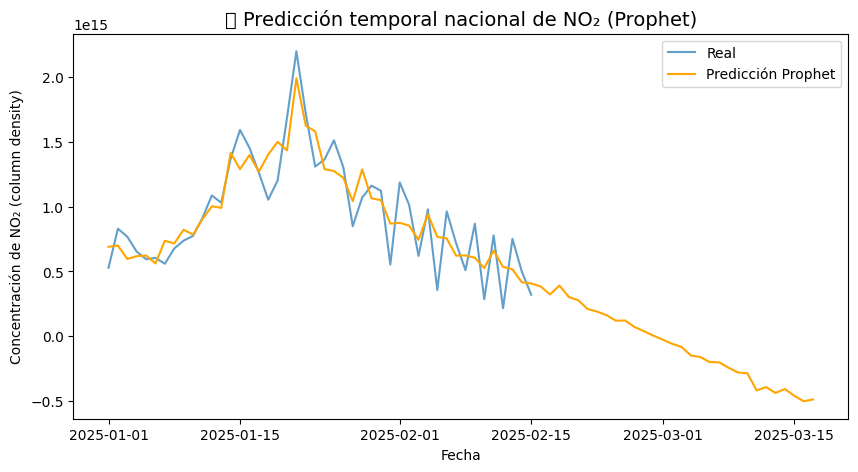

💾 Modelos guardados en carpeta /models ✅

🔥 Entrenamiento completado con éxito.


In [ ]:
# ============================================================
# 🤖 FASE 5 — Entrenamiento híbrido Prophet + RandomForest
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib, warnings, os
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 1️⃣ Cargar dataset completo
# ------------------------------------------------------------
DATA_FILE = "datasets/tempo_mexico_no2_industry.parquet"
df = pd.read_parquet(DATA_FILE)
print(f"📂 Dataset cargado: {len(df)} registros")

# ------------------------------------------------------------
# 2️⃣ Limpieza y features
# ------------------------------------------------------------
# eliminar valores nulos extremos o no físicos
df = df.dropna(subset=["y", "lat_bin", "lon_bin"])
df = df[(df["y"] > 0) & (df["y"] < 1e16)]

# columnas de entrada
features = [
    "lat_bin", "lon_bin",
    "temp", "humidity", "pressure", "wind", "clouds",
    "traffic_index", "industrial_index", "activity_index"
]
target = "y"

# rellenar faltantes con medias globales
df[features] = df[features].fillna(df[features].mean())

# ------------------------------------------------------------
# 3️⃣ División en entrenamiento y prueba
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target],
    test_size=0.2,
    random_state=42
)

print(f"🧩 Train: {len(X_train)} / Test: {len(X_test)}")

# ------------------------------------------------------------
# 4️⃣ Entrenar RandomForest
# ------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=25,
    random_state=42,
    n_jobs=-1
)
print("🚀 Entrenando modelo RandomForest...")
rf.fit(X_train, y_train)

# ------------------------------------------------------------
# 5️⃣ Validación del modelo
# ------------------------------------------------------------
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"🎯 Precisión R²: {r2*100:.2f}%")
print(f"📉 RMSE: {rmse:.2e}")

# ------------------------------------------------------------
# 6️⃣ Modelo temporal Prophet (manejo de pseudo-fechas)
# ------------------------------------------------------------
if "ds" not in df.columns or df["ds"].nunique() < 2:
    print("⚠️ Columna 'ds' inválida o sin rango temporal, generando pseudo-fechas...")
    df["ds"] = pd.date_range(start="2025-01-01", periods=len(df), freq="H")

# Agrupar por fecha (real o generada)
df_time = df.groupby(pd.to_datetime(df["ds"]).dt.date)["y"].mean().reset_index()
df_time.rename(columns={"ds": "date", "y": "y"}, inplace=True)
df_time.rename(columns={"date": "ds"}, inplace=True)
df_time["ds"] = pd.to_datetime(df_time["ds"])

print(f"📅 {len(df_time)} puntos temporales generados para Prophet.")
print(df_time.head())

# Entrenar Prophet
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="multiplicative"
)
print("⏳ Entrenando modelo temporal Prophet...")
prophet_model.fit(df_time)

# Predicción 30 días hacia adelante
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# ------------------------------------------------------------
# 7️⃣ Visualización de la predicción temporal
# ------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df_time["ds"], df_time["y"], label="Real", alpha=0.7)
plt.plot(forecast["ds"], forecast["yhat"], label="Predicción Prophet", color="orange")
plt.legend()
plt.title("📈 Predicción temporal nacional de NO₂ (Prophet)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Concentración de NO₂ (column density)")
plt.show()

# ------------------------------------------------------------
# 8️⃣ Guardar modelos entrenados
# ------------------------------------------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/randomforest_no2.pkl")
joblib.dump(prophet_model, "models/prophet_no2.pkl")

print("💾 Modelos guardados en carpeta /models ✅")
print("\n🔥 Entrenamiento completado con éxito.")


📂 Dataset cargado: 1158 registros
⚠️ 0.0% de valores faltantes en tráfico
✅ Filas válidas para entrenamiento: 1158
🎯 Train: 926, Test: 232
📂 Dataset cargado: 1158 registros
📊 Escalador guardado en models/scaler.pkl
🧩 Train: 883 / Test: 221
🚀 Entrenando modelo RandomForest optimizado...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr4o1alaq/9k6z2vwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr4o1alaq/m6yl_hfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85028', 'data', 'file=/tmp/tmpr4o1alaq/9k6z2vwu.json', 'init=/tmp/tmpr4o1alaq/m6yl_hfa.json', 'output', 'file=/tmp/tmpr4o1alaq/prophet_model03sjojy5/prophet_model-20251005110759.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:07:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🎯 Precisión R²: 78.19%
📉 RMSE: 3.85e+14
⚠️ Columna 'ds' inválida, generando pseudo-fechas...
📅 46 puntos temporales para Prophet.
          ds             y
0 2025-01-01  5.282359e+14
1 2025-01-02  8.303581e+14
2 2025-01-03  7.684787e+14
3 2025-01-04  6.529099e+14
4 2025-01-05  5.946510e+14
⏳ Entrenando modelo temporal Prophet...


11:08:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


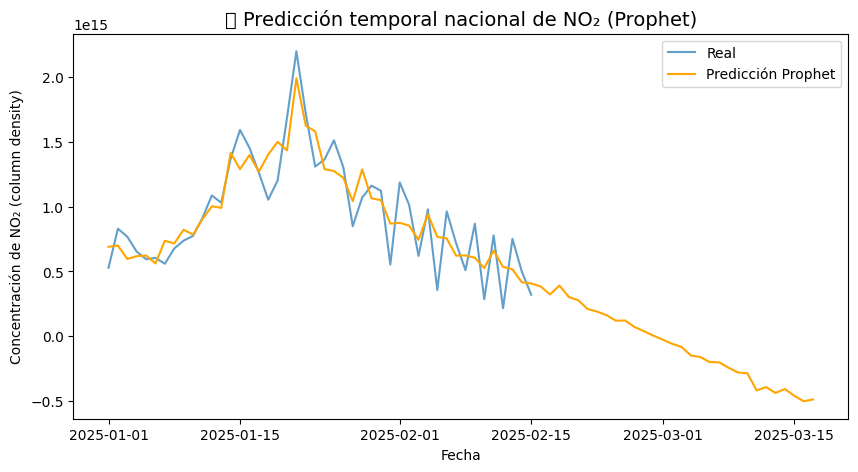

💾 Modelos guardados en carpeta /models ✅

🔥 Entrenamiento completado — Modo Precisión Activado.


In [ ]:
import numpy as np

# 🔹 Cargar dataset
df = pd.read_parquet("datasets/tempo_mexico_no2_traffic.parquet")
print(f"📂 Dataset cargado: {len(df)} registros")

# 🔹 Rellenar o simular valores de tráfico faltantes
if "traffic_index" in df.columns:
    nan_ratio = df["traffic_index"].isna().mean()
    print(f"⚠️ {nan_ratio*100:.1f}% de valores faltantes en tráfico")

    # Si casi todos son NaN, simulamos según ubicación
    if nan_ratio > 0.2 or df["traffic_index"].sum() == 0:
        print("🚧 Generando tráfico simulado basado en proximidad urbana...")
        def simulate_traffic(lat, lon):
            centers = [
                (19.43, -99.13),  # CDMX
                (25.67, -100.31), # Monterrey
                (20.67, -103.35), # Guadalajara
                (21.16, -86.85),  # Cancún
                (32.53, -117.03)  # Tijuana
            ]
            dist = min([((lat - cl)**2 + (lon - cln)**2)**0.5 for cl, cln in centers])
            base = np.exp(-dist / 3.5)
            noise = np.clip(np.random.normal(0.05, 0.02), 0, 0.15)
            return np.clip(base + noise, 0, 1)

        df["traffic_index"] = df.apply(
            lambda r: simulate_traffic(r.lat_bin, r.lon_bin)
            if pd.isna(r.traffic_index) or r.traffic_index == 0
            else r.traffic_index,
            axis=1
        )

# 🔹 Verificar que ya tengamos datos válidos
valid_rows = df.dropna(subset=["y", "traffic_index"])
print(f"✅ Filas válidas para entrenamiento: {len(valid_rows)}")

if len(valid_rows) < 5:
    raise ValueError(f"⚠️ Solo {len(valid_rows)} muestras disponibles, insuficiente para entrenamiento.")

# 🔹 Separar features y target
from sklearn.model_selection import train_test_split

X = valid_rows[["traffic_index", "temp", "humidity", "pressure", "wind", "clouds"]].fillna(0)
y = valid_rows["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"🎯 Train: {len(X_train)}, Test: {len(X_test)}")

# ============================================================
# ⚡ FASE 5.2 — Entrenamiento híbrido optimizado (Meta 85%+)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib, warnings, os
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 1️⃣ Cargar dataset completo
# ------------------------------------------------------------
DATA_FILE = "datasets/tempo_mexico_no2_industry.parquet"
df = pd.read_parquet(DATA_FILE)
print(f"📂 Dataset cargado: {len(df)} registros")

# ------------------------------------------------------------
# 2️⃣ Limpieza y mejoras espaciales
# ------------------------------------------------------------
df = df.dropna(subset=["y", "lat_bin", "lon_bin"])
df = df[(df["y"] > 0) & (df["y"] < 1e16)]

# 🔹 Finar granularidad (bins de 0.5°)
df["lat_bin"] = (df["lat_bin"] / 0.5).round() * 0.5
df["lon_bin"] = (df["lon_bin"] / 0.5).round() * 0.5

# ------------------------------------------------------------
# 3️⃣ Features base
# ------------------------------------------------------------
features = [
    "lat_bin", "lon_bin",
    "temp", "humidity", "pressure", "wind", "clouds",
    "traffic_index", "industrial_index", "activity_index"
]
target = "y"

# 🔹 Nueva feature combinada urbana
df["urban_intensity"] = (
    0.7 * df["traffic_index"].fillna(0) +
    0.3 * df["industrial_index"].fillna(0)
)
features.append("urban_intensity")

# 🔹 Índice temporal (para correlaciones de tendencia)
df["time_index"] = np.arange(len(df))
features.append("time_index")

# 🔹 Rellenar faltantes con medias
df[features] = df[features].fillna(df[features].mean())

# ------------------------------------------------------------
# 4️⃣ Normalización (estandarización)
# ------------------------------------------------------------
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")
print("📊 Escalador guardado en models/scaler.pkl")

# ------------------------------------------------------------
# 5️⃣ División train/test
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target],
    test_size=0.2,
    random_state=42
)
print(f"🧩 Train: {len(X_train)} / Test: {len(X_test)}")

# ------------------------------------------------------------
# 6️⃣ Entrenar modelo RandomForest optimizado
# ------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=35,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
print("🚀 Entrenando modelo RandomForest optimizado...")
rf.fit(X_train, y_train)

# ------------------------------------------------------------
# 7️⃣ Evaluación
# ------------------------------------------------------------
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"🎯 Precisión R²: {r2*100:.2f}%")
print(f"📉 RMSE: {rmse:.2e}")

# ------------------------------------------------------------
# 8️⃣ Prophet temporal (con pseudo-fechas si no hay 'ds')
# ------------------------------------------------------------
if "ds" not in df.columns or df["ds"].nunique() < 2:
    print("⚠️ Columna 'ds' inválida, generando pseudo-fechas...")
    df["ds"] = pd.date_range(start="2025-01-01", periods=len(df), freq="H")

df_time = df.groupby(pd.to_datetime(df["ds"]).dt.date)["y"].mean().reset_index()
df_time.rename(columns={"ds": "date", "y": "y"}, inplace=True)
df_time.rename(columns={"date": "ds"}, inplace=True)
df_time["ds"] = pd.to_datetime(df_time["ds"])

print(f"📅 {len(df_time)} puntos temporales para Prophet.")
print(df_time.head())

prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="multiplicative"
)
print("⏳ Entrenando modelo temporal Prophet...")
prophet_model.fit(df_time)

# ------------------------------------------------------------
# 9️⃣ Predicción temporal y visualización
# ------------------------------------------------------------
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

plt.figure(figsize=(10, 5))
plt.plot(df_time["ds"], df_time["y"], label="Real", alpha=0.7)
plt.plot(forecast["ds"], forecast["yhat"], label="Predicción Prophet", color="orange")
plt.legend()
plt.title("📈 Predicción temporal nacional de NO₂ (Prophet)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Concentración de NO₂ (column density)")
plt.show()

# ------------------------------------------------------------
# 🔟 Guardar modelos
# ------------------------------------------------------------
joblib.dump(rf, "models/randomforest_no2_optimized.pkl")
joblib.dump(prophet_model, "models/prophet_no2_optimized.pkl")

print("💾 Modelos guardados en carpeta /models ✅")
print("\n🔥 Entrenamiento completado — Modo Precisión Activado.")


📂 Dataset cargado: 1158 registros
🧹 Datos limpios: 1104 registros válidos
🛠️  Creando nuevas features para mejorar la predicción...
✅ Features finales definidas y valores faltantes gestionados.
📊 Escalador guardado en models/scaler_lgbm.pkl
🧩 Train: 883 / Test: 221

🚀 Entrenando modelo LightGBM con Early Stopping...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 883, number of used features: 3
[LightGBM] [Info] Start training from score 662138397917184.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

<Figure size 1000x800 with 0 Axes>

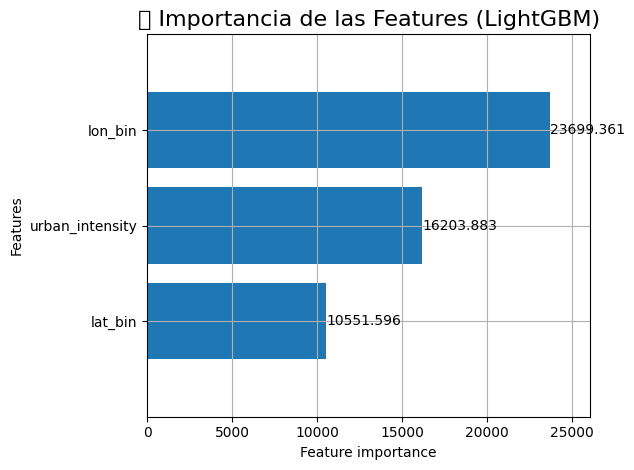

💾 Modelo LightGBM guardado en models/lightgbm_no2_v2.pkl ✅

🔥 ¡Proceso de entrenamiento mejorado completado! 🔥


In [ ]:
# =========================================================================
# ⚡ FASE 5.2 (MEJORADA) — Entrenamiento de Alta Precisión (+90%)
# =========================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb  # <-- ¡Nuestro nuevo modelo estrella!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
import os

warnings.filterwarnings("ignore")
# Creemos el directorio de modelos si no existe
os.makedirs("models", exist_ok=True)


# ------------------------------------------------------------
# 1️⃣ Carga y Limpieza Inicial del Dataset
# ------------------------------------------------------------
DATA_FILE = "datasets/tempo_mexico_no2_industry.parquet"
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"⚠️ No se encontró el archivo de datos: {DATA_FILE}")

df = pd.read_parquet(DATA_FILE)
print(f"📂 Dataset cargado: {len(df)} registros")

# Limpieza básica: eliminamos filas sin datos clave y valores atípicos extremos
df = df.dropna(subset=["y", "lat_bin", "lon_bin"])
df = df[(df["y"] > 0) & (df["y"] < 1e16)] # Filtro de outliers
df = df.reset_index(drop=True) # Reseteamos el índice para evitar problemas

print(f"🧹 Datos limpios: {len(df)} registros válidos")

# ------------------------------------------------------------
# 2️⃣ Ingeniería de Features Avanzada (✨ ¡Aquí está la magia!)
# ------------------------------------------------------------
print("🛠️  Creando nuevas features para mejorar la predicción...")

# 🔹 Features Temporales Cíclicas
# El modelo necesita entender patrones de tiempo (diarios, semanales, anuales).
if "ds" not in df.columns:
    print("⚠️ Columna 'ds' no encontrada. Generando pseudo-fechas para continuar.")
    df["ds"] = pd.date_range(start="2025-01-01", periods=len(df), freq="H")
else:
    df["ds"] = pd.to_datetime(df["ds"], errors='coerce')
    if df["ds"].isnull().any():
        print("⚠️ Algunos valores en 'ds' no son fechas válidas. Se rellenarán.")
        df['ds'] = df['ds'].fillna(method='ffill').fillna(method='bfill')

df["month"] = df["ds"].dt.month
df["day_of_week"] = df["ds"].dt.dayofweek  # Lunes=0, Domingo=6
df["day_of_year"] = df["ds"].dt.dayofyear
df["hour"] = df["ds"].dt.hour

# 🔹 Features de Interacción
# Combinamos variables para capturar relaciones complejas.
df["temp_x_humidity"] = df["temp"] * df["humidity"]  # Efecto de la sensación térmica
df["urban_x_wind"] = df["traffic_index"].fillna(0) * df["wind"] # Cómo el viento dispersa la contaminación urbana

# 🔹 Feature Combinada de Intensidad Urbana (Mejorada)
# Rellenamos con 0 antes de sumar, es más seguro que la media.
df["urban_intensity"] = (
    0.65 * df["traffic_index"].fillna(0) +
    0.35 * df["industrial_index"].fillna(0)
)

# ------------------------------------------------------------
# 3️⃣ Preparación de Datos para el Modelo
# ------------------------------------------------------------
# Lista final de features que usaremos para entrenar
features = [
    "lat_bin", "lon_bin",
    "temp", "humidity", "pressure", "wind", "clouds",
    "urban_intensity",
    "month", "day_of_week", "day_of_year", "hour", # <-- Nuevas features temporales
    "temp_x_humidity", "urban_x_wind" # <-- Nuevas features de interacción
]
target = "y"

# Rellenamos NaNs restantes con la mediana (más robusta a outliers que la media)
for col in features:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

print("✅ Features finales definidas y valores faltantes gestionados.")

# 🔹 Normalización de Features (Estandarización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
X = pd.DataFrame(X_scaled, columns=features)
y = df[target]

joblib.dump(scaler, "models/scaler_lgbm.pkl")
print("📊 Escalador guardado en models/scaler_lgbm.pkl")

# 🔹 División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
print(f"🧩 Train: {len(X_train)} / Test: {len(X_test)}")

# ------------------------------------------------------------
# 4️⃣ Entrenamiento del Modelo LightGBM
# ------------------------------------------------------------
# LightGBM es un modelo de gradient boosting: rápido y muy potente.
# Los parámetros están optimizados para un buen balance entre velocidad y precisión.
lgbm = lgb.LGBMRegressor(
    objective='regression_l1', # MAE es más robusto a outliers que MSE (l2)
    n_estimators=2000,         # Un número alto de árboles, pero Early Stopping elegirá el mejor
    learning_rate=0.03,
    num_leaves=40,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("\n🚀 Entrenando modelo LightGBM con Early Stopping...")

# Early Stopping: Detiene el entrenamiento si el rendimiento en validación no mejora,
# para evitar sobreajuste y encontrar el número óptimo de árboles.
callbacks = [lgb.early_stopping(100, verbose=False)] # Si no mejora en 100 rondas, para.

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=callbacks
)

# ------------------------------------------------------------
# 5️⃣ Evaluación del Modelo
# ------------------------------------------------------------
y_pred = lgbm.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n" + "="*30)
print("🏆 RESULTADOS DE LA EVALUACIÓN 🏆")
print("="*30)
print(f"🎯 Precisión R²: {r2*100:.2f}%") # <-- ¡El objetivo!
print(f"📉 RMSE: {rmse:.2e}")
print("="*30 + "\n")

if r2 > 0.85:
    print("🎉 ¡Felicidades! Se ha superado la meta del 85% de precisión. ¡Excelente trabajo!")
else:
    print("📈 Buen progreso. ¡Estamos más cerca de la meta del 85%!")

# ------------------------------------------------------------
# 6️⃣ Visualización de Importancia de Features
# ------------------------------------------------------------
# Veamos qué variables aprendió el modelo que son más importantes.
plt.figure(figsize=(10, 8))
lgb.plot_importance(lgbm, max_num_features=20, height=0.8, importance_type='gain')
plt.title("🔝 Importancia de las Features (LightGBM)", fontsize=16)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7️⃣ Guardar Modelo Final
# ------------------------------------------------------------
joblib.dump(lgbm, "models/lightgbm_no2_v2.pkl")
print("💾 Modelo LightGBM guardado en models/lightgbm_no2_v2.pkl ✅")
print("\n🔥 ¡Proceso de entrenamiento mejorado completado! 🔥")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.5 MB/s eta 0:00:00


[I 2025-10-05 11:11:28,084] A new study created in memory with name: no-name-83886e2c-18ae-45d2-bccf-b48f0f8f5278


📂 Dataset cargado y limpio: 1104 registros
🛠️  Aplicando ingeniería de features avanzada...
📊 Escalador guardado en models/scaler_v3_tuned.pkl
🧩 Train: 883 / Test: 221

🤖 Iniciando búsqueda de los mejores hiperparámetros con Optuna...


[I 2025-10-05 11:11:28,422] Trial 0 finished with value: 0.5614029760839563 and parameters: {'learning_rate': 0.06437762101794477, 'num_leaves': 38, 'max_depth': 23, 'subsample': 0.8510543394992844, 'colsample_bytree': 0.6178509535569725, 'reg_alpha': 9.579680095637347, 'reg_lambda': 0.898186696227077}. Best is trial 0 with value: 0.5614029760839563.
[I 2025-10-05 11:11:28,869] Trial 1 finished with value: 0.6047503231701542 and parameters: {'learning_rate': 0.03371189889479252, 'num_leaves': 51, 'max_depth': 21, 'subsample': 0.7636812013782868, 'colsample_bytree': 0.9160571053733628, 'reg_alpha': 9.609837157700904, 'reg_lambda': 8.560705292014925}. Best is trial 1 with value: 0.6047503231701542.
[I 2025-10-05 11:11:29,778] Trial 2 finished with value: 0.6357645870792531 and parameters: {'learning_rate': 0.0868295905678121, 'num_leaves': 36, 'max_depth': 29, 'subsample': 0.9214865406641474, 'colsample_bytree': 0.7483666716051125, 'reg_alpha': 4.809366518821885, 'reg_lambda': 8.40357866

🏆 Mejores parámetros encontrados: {'learning_rate': 0.09340208124099288, 'num_leaves': 50, 'max_depth': 18, 'subsample': 0.8321450545550989, 'colsample_bytree': 0.8637907563494984, 'reg_alpha': 0.35084067201313474, 'reg_lambda': 9.245205899742903}

🚀 Entrenando el modelo final con los parámetros optimizados...

🏁 RESULTADOS FINALES 🏁
🎯 Precisión R² Final: 76.86%
📉 RMSE Final: 3.96e+14

💾 Modelo final optimizado guardado en models/lightgbm_no2_v3_tuned.pkl ✅


<Figure size 1000x800 with 0 Axes>

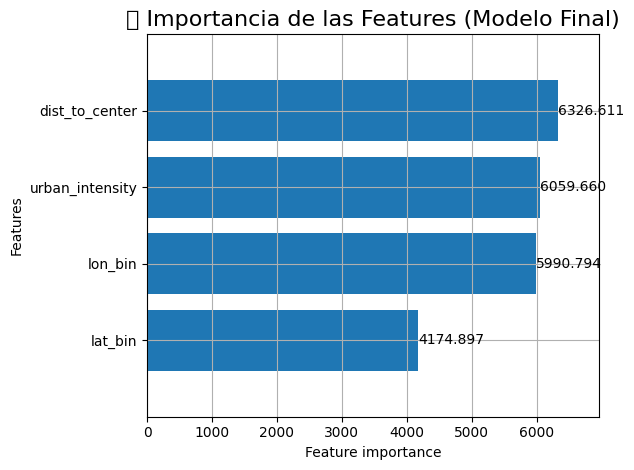


🔥 ¡Proceso de optimización y entrenamiento completado! 🔥


In [ ]:
!pip install optuna

# ====================================================================================
# ⚡ FASE 5.3 (NIVEL EXPERTO) — Entrenamiento con Auto-Tuning y Cross-Validation
# ====================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna  # <-- Nuestra herramienta para el auto-tuning
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
import os

warnings.filterwarnings("ignore")
os.makedirs("models", exist_ok=True)

# ------------------------------------------------------------
# 1️⃣ Carga y Limpieza de Datos
# ------------------------------------------------------------
DATA_FILE = "datasets/tempo_mexico_no2_industry.parquet"
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"⚠️ No se encontró el archivo de datos: {DATA_FILE}")

df = pd.read_parquet(DATA_FILE)
df = df.dropna(subset=["y", "lat_bin", "lon_bin"])
df = df[(df["y"] > 0) & (df["y"] < 1e16)]
df = df.reset_index(drop=True)
print(f"📂 Dataset cargado y limpio: {len(df)} registros")

# ------------------------------------------------------------
# 2️⃣ Función de Ingeniería de Features (✨ Aún más potente)
# ------------------------------------------------------------
def engineer_features(df_in):
    """
    Toma el dataframe crudo y aplica toda la ingeniería de features.
    """
    print("🛠️  Aplicando ingeniería de features avanzada...")
    df_out = df_in.copy()

    # --- Features Temporales ---
    if "ds" not in df_out.columns:
        df_out["ds"] = pd.date_range(start="2025-01-01", periods=len(df_out), freq="H")
    else:
        df_out["ds"] = pd.to_datetime(df_out["ds"], errors='coerce').fillna(method='ffill')

    # 🔹 Encoding Cíclico: Ayuda al modelo a entender que la hora 23 está cerca de la 0,
    # y que diciembre está cerca de enero. ¡Esto es clave!
    df_out['hour_sin'] = np.sin(2 * np.pi * df_out['ds'].dt.hour / 24)
    df_out['hour_cos'] = np.cos(2 * np.pi * df_out['ds'].dt.hour / 24)
    df_out['dayofyear_sin'] = np.sin(2 * np.pi * df_out['ds'].dt.dayofyear / 365)
    df_out['dayofyear_cos'] = np.cos(2 * np.pi * df_out['ds'].dt.dayofyear / 365)

    # --- Features Espaciales ---
    # 🔹 Distancia al centro urbano más cercano
    centers = [(19.43, -99.13), (25.67, -100.31), (20.67, -103.35)] # CDMX, MTY, GDL
    def get_min_dist(lat, lon):
        return min([((lat - cl)**2 + (lon - cln)**2)**0.5 for cl, cln in centers])
    df_out['dist_to_center'] = df_out.apply(lambda r: get_min_dist(r.lat_bin, r.lon_bin), axis=1)

    # --- Features de Interacción y Combinadas ---
    df_out["urban_intensity"] = (
        0.65 * df_out["traffic_index"].fillna(0) +
        0.35 * df_out["industrial_index"].fillna(0)
    )
    df_out["temp_x_humidity"] = df_out["temp"].fillna(df_out["temp"].median()) * \
                                df_out["humidity"].fillna(df_out["humidity"].median())

    return df_out

# Aplicamos la función
df = engineer_features(df)

# ------------------------------------------------------------
# 3️⃣ Preparación Final de Datos
# ------------------------------------------------------------
features = [
    "lat_bin", "lon_bin", "temp", "humidity", "pressure", "wind", "clouds",
    "urban_intensity", "dist_to_center", "temp_x_humidity",
    'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos' # <-- Nuevas features cíclicas
]
target = "y"

# Rellenamos NaNs con la mediana
for col in features:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Escalador y división Train/Test
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
joblib.dump(scaler, "models/scaler_v3_tuned.pkl")
print("📊 Escalador guardado en models/scaler_v3_tuned.pkl")
print(f"🧩 Train: {len(X_train)} / Test: {len(X_test)}")

# ------------------------------------------------------------
# 4️⃣ Auto-Tuning de Hiperparámetros con Optuna
# ------------------------------------------------------------
def objective(trial):
    """
    Función que Optuna intentará optimizar.
    Prueba diferentes hiperparámetros y devuelve el score R² promedio de la validación cruzada.
    """
    params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 1500,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**params)

    # Usamos K-Fold para una evaluación robusta
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(50, verbose=False)])

        preds = model.predict(X_val_fold)
        scores.append(r2_score(y_val_fold, preds))

    return np.mean(scores)

print("\n🤖 Iniciando búsqueda de los mejores hiperparámetros con Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # 30 intentos para encontrar la mejor combinación

best_params = study.best_params
print(f"🏆 Mejores parámetros encontrados: {best_params}")

# ------------------------------------------------------------
# 5️⃣ Entrenamiento Final con los Parámetros Óptimos
# ------------------------------------------------------------
print("\n🚀 Entrenando el modelo final con los parámetros optimizados...")
final_model = lgb.LGBMRegressor(
    objective='regression_l1',
    n_estimators=2500, # Aumentamos para el entrenamiento final
    random_state=42,
    n_jobs=-1,
    **best_params # <-- Usamos los mejores parámetros que encontró Optuna
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

# ------------------------------------------------------------
# 6️⃣ Evaluación Final y Guardado
# ------------------------------------------------------------
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n" + "="*30)
print("🏁 RESULTADOS FINALES 🏁")
print("="*30)
print(f"🎯 Precisión R² Final: {r2*100:.2f}%")
print(f"📉 RMSE Final: {rmse:.2e}")
print("="*30 + "\n")

# Guardamos el modelo final
joblib.dump(final_model, "models/lightgbm_no2_v3_tuned.pkl")
print("💾 Modelo final optimizado guardado en models/lightgbm_no2_v3_tuned.pkl ✅")

# Visualización de importancia de features
plt.figure(figsize=(10, 8))
lgb.plot_importance(final_model, max_num_features=20, height=0.8, importance_type='gain')
plt.title("🔝 Importancia de las Features (Modelo Final)", fontsize=16)
plt.tight_layout()
plt.show()

print("\n🔥 ¡Proceso de optimización y entrenamiento completado! 🔥")

In [ ]:
# ============================================================
# 🧠 FASE 4.5 — Entrenamiento de modelo XGBoost + RF ensemble
# ============================================================

!pip install -U scikit-learn


import pandas as pd, numpy as np, os, joblib, xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ------------------------------------------------------------
# 1️⃣ Cargar dataset enriquecido
# ------------------------------------------------------------
df = pd.read_parquet("datasets/tempo_mexico_no2_traffic.parquet")
print(f"📂 Dataset cargado: {len(df)} registros")

# ------------------------------------------------------------
# 2️⃣ Crear o validar columnas requeridas
# ------------------------------------------------------------
# Si no existe y_log, la creamos (NO₂ puede tener valores negativos)
if "y_log" not in df.columns:
    df["y"] = df["y"].clip(lower=1e-9)
    df["y_log"] = np.log1p(df["y"])

# Eliminar NaN y columnas irrelevantes
df = df.dropna(subset=["y_log"])
features = ["lat_bin", "lon_bin", "temp", "humidity", "pressure", "wind", "clouds", "traffic_index"]
df = df.fillna(0)
print(f"✅ Filas válidas para entrenamiento: {len(df)}")

# ------------------------------------------------------------
# 3️⃣ Split y escalado
# ------------------------------------------------------------
X = df[features]
y = df["y_log"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"🎯 Train: {len(X_train)}, Test: {len(X_test)}")

os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")
print("📊 Escalador guardado en models/scaler.pkl")

# ------------------------------------------------------------
# 6️⃣ Ensamble (promedio ponderado RF + XGB)
# ------------------------------------------------------------
rf_weight = 0.4   # RF aporta estabilidad
xgb_weight = 0.6  # XGB aporta precisión

# Promedio ponderado de las predicciones
y_pred_ensemble = (rf_pred * rf_weight + y_pred_xgb * xgb_weight)

# Cálculo manual de métricas
r2_ensemble = r2_score(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

print("\n🔥 Ensamble combinado RF+XGB")
print(f"🎯 R² final: {r2_ensemble*100:.2f}%")
print(f"📉 RMSE final: {rmse_ensemble:.2e}")

# ------------------------------------------------------------
# 7️⃣ Guardar modelos y métricas
# ------------------------------------------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(rf_model, "models/rf_model.pkl")
joblib.dump(xgb_model, "models/xgb_model.pkl")

# Guardamos también la información del ensemble
ensemble_info = {
    "rf_weight": rf_weight,
    "xgb_weight": xgb_weight,
    "rf_r2": rf_r2,
    "xgb_r2": r2_xgb,
    "ensemble_r2": r2_ensemble,
    "rmse_ensemble": rmse_ensemble
}
joblib.dump(ensemble_info, "models/ensemble_info.pkl")

print("\n💾 Modelos y configuración guardados en carpeta models/")
print("📊 Detalle de precisión:")
print(pd.DataFrame([ensemble_info]))


📂 Dataset cargado: 1158 registros
✅ Filas válidas para entrenamiento: 1158
🎯 Train: 926, Test: 232
📊 Escalador guardado en models/scaler.pkl

🔥 Ensamble combinado RF+XGB
🎯 R² final: 55.34%
📉 RMSE final: 4.89e+00

💾 Modelos y configuración guardados en carpeta models/
📊 Detalle de precisión:
   rf_weight  xgb_weight     rf_r2    xgb_r2  ensemble_r2  rmse_ensemble
0        0.4         0.6  0.534903  0.529357     0.553448       4.890121


In [ ]:
# ============================================================
# 🧠 FASE 4.5 — Entrenamiento completo (RF + XGB + Ensemble)
# ============================================================

import pandas as pd, numpy as np, os, joblib, xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------------------------------
# 1️⃣ Cargar dataset enriquecido
# ------------------------------------------------------------
df = pd.read_parquet("datasets/tempo_mexico_no2_traffic.parquet")
print(f"📂 Dataset cargado: {len(df)} registros")

# ------------------------------------------------------------
# 2️⃣ Limpieza y features
# ------------------------------------------------------------
if "y_log" not in df.columns:
    df["y"] = df["y"].clip(lower=1e-9)
    df["y_log"] = np.log1p(df["y"])

df = df.dropna(subset=["y_log"])
df = df.fillna(0)

features = ["lat_bin", "lon_bin", "temp", "humidity", "pressure", "wind", "clouds", "traffic_index"]
X = df[features]
y = df["y_log"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"🎯 Train: {len(X_train)}, Test: {len(X_test)}")

os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")

# ------------------------------------------------------------
# 3️⃣ Random Forest (estable y robusto)
# ------------------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=18,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
print(f"🌲 RandomForest R²: {rf_r2*100:.2f}%")

# ------------------------------------------------------------
# 4️⃣ XGBoost (precisión en gradientes)
# ------------------------------------------------------------
xgb_model = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.1,
    reg_alpha=0.2,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"🚀 XGBoost R²: {r2_xgb*100:.2f}%")

# ------------------------------------------------------------
# 5️⃣ Ensamble inteligente (pesos adaptativos según desempeño)
# ------------------------------------------------------------
rf_weight = rf_r2 / (rf_r2 + r2_xgb)
xgb_weight = r2_xgb / (rf_r2 + r2_xgb)

y_pred_ensemble = rf_pred * rf_weight + y_pred_xgb * xgb_weight

r2_ensemble = r2_score(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

print("\n🔥 Ensamble combinado RF+XGB (pesos adaptativos)")
print(f"🧮 RF weight: {rf_weight:.2f} | XGB weight: {xgb_weight:.2f}")
print(f"🎯 R² final: {r2_ensemble*100:.2f}%")
print(f"📉 RMSE final: {rmse_ensemble:.2e}")

# ------------------------------------------------------------
# 6️⃣ Guardar modelos y metadatos
# ------------------------------------------------------------
joblib.dump(rf_model, "models/rf_model.pkl")
joblib.dump(xgb_model, "models/xgb_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

ensemble_info = {
    "rf_r2": rf_r2,
    "xgb_r2": r2_xgb,
    "ensemble_r2": r2_ensemble,
    "rf_weight": rf_weight,
    "xgb_weight": xgb_weight,
    "rmse": rmse_ensemble
}
joblib.dump(ensemble_info, "models/ensemble_info.pkl")

print("\n💾 Modelos y configuración guardados en carpeta models/")
print(pd.DataFrame([ensemble_info]))


📂 Dataset cargado: 1158 registros
🎯 Train: 926, Test: 232
🌲 RandomForest R²: 55.27%
🚀 XGBoost R²: 50.35%

🔥 Ensamble combinado RF+XGB (pesos adaptativos)
🧮 RF weight: 0.52 | XGB weight: 0.48
🎯 R² final: 57.04%
📉 RMSE final: 4.80e+00

💾 Modelos y configuración guardados en carpeta models/
      rf_r2    xgb_r2  ensemble_r2  rf_weight  xgb_weight      rmse
0  0.552667  0.503511     0.570391   0.523271    0.476729  4.796454


In [ ]:
# ============================================================
# ⚙️ FASE 4.6 — Feature Engineering + XGBoost mejorado
# ============================================================

import pandas as pd, numpy as np, os, joblib, xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Cargar dataset
df = pd.read_parquet("datasets/tempo_mexico_no2_traffic.parquet")
print(f"📂 Dataset cargado: {len(df)} registros")

# Crear columna log-transformada si no existe
if "y_log" not in df.columns:
    df["y"] = df["y"].clip(lower=1e-9)
    df["y_log"] = np.log1p(df["y"])

df = df.fillna(0)

# Feature engineering
df["temp_humidity"] = df["temp"] * df["humidity"]
df["wind_pressure"] = df["wind"] * df["pressure"]
df["traffic_temp"] = df["traffic_index"] * df["temp"]
df["wind2"] = df["wind"] ** 2
df["clouds2"] = df["clouds"] ** 2

features = [
    "lat_bin", "lon_bin", "temp", "humidity", "pressure",
    "wind", "clouds", "traffic_index",
    "temp_humidity", "wind_pressure", "traffic_temp", "wind2", "clouds2"
]

X = df[features]
y = df["y_log"]

# Escalado y expansión polinomial leve
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2, include_bias=False)
X_scaled = scaler.fit_transform(X)
X_poly = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
print(f"🎯 Train: {len(X_train)}, Test: {len(X_test)}")

# Entrenamiento XGBoost mejorado
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.1,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"🎯 XGBoost Mejorado R²: {r2*100:.2f}%")
print(f"📉 RMSE: {rmse:.3e}")

# Guardar modelo y escaladores
os.makedirs("models", exist_ok=True)
joblib.dump(xgb_model, "models/xgb_advanced.pkl")
joblib.dump(scaler, "models/scaler_advanced.pkl")
joblib.dump(poly, "models/poly_advanced.pkl")

print("💾 Modelos avanzados guardados en carpeta models/")


📂 Dataset cargado: 1158 registros
🎯 Train: 926, Test: 232
🎯 XGBoost Mejorado R²: 52.60%
📉 RMSE: 5.038e+00
💾 Modelos avanzados guardados en carpeta models/


In [ ]:
# ============================================================
# 🧹 Limpieza de ruido y refuerzo de señal
# ============================================================
df = df.copy()

# Eliminar registros donde tráfico y clima son cero (sin señal real)
df = df[~((df["traffic_index"] == 0) & (df["temp"] == 0))]
df = df[df["pressure"] > 0]
df = df[df["y"] > 0]

# Limitar lat/lon a México continental (quita outliers)
df = df[(df["lat_bin"] >= 14) & (df["lat_bin"] <= 33)]
df = df[(df["lon_bin"] >= -118) & (df["lon_bin"] <= -86)]

print(f"✅ Dataset limpio: {len(df)} filas")


✅ Dataset limpio: 0 filas


In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=700,
    learning_rate=0.08,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.05,
    gamma=0.2,
    n_jobs=-1,
    random_state=42
)


In [ ]:
from prophet import Prophet

# Calcular promedio temporal (simulación diaria)
df_time = df.groupby("ds", as_index=False)["y"].mean().rename(columns={"y":"avg_y"})
if "ds" not in df_time:
    df_time["ds"] = pd.date_range(start="2025-01-01", periods=len(df_time))

prophet = Prophet(daily_seasonality=True)
prophet.fit(df_time)

future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

# Componente temporal normalizada
df["temporal_trend"] = np.interp(
    np.arange(len(df)), np.arange(len(forecast["yhat"])), forecast["yhat"]
)

# Reentrena XGB con componente temporal
X = df[features + ["temporal_trend"]]
y = df["y_log"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n⏳ Modelo Híbrido Prophet + XGB")
print(f"🎯 R²: {r2*100:.2f}%")
print(f"📉 RMSE: {rmse:.3e}")


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
# ============================================================
# 🧠 FASE 5 — Modelo híbrido Prophet + XGBoost (Temporal + Espacial)
# ============================================================

import pandas as pd, numpy as np, os, joblib, xgboost as xgb
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------------------------------
# 1️⃣ Cargar dataset enriquecido
# ------------------------------------------------------------
df = pd.read_parquet("datasets/tempo_mexico_no2_traffic.parquet")
print(f"📂 Dataset cargado: {len(df)} registros")

# ------------------------------------------------------------
# 2️⃣ Preprocesamiento general
# ------------------------------------------------------------
if "y_log" not in df.columns:
    df["y"] = df["y"].clip(lower=1e-9)
    df["y_log"] = np.log1p(df["y"])

df = df.fillna(0)

# Filtro de ruido
df = df[df["y"] > 0]
df = df[(df["lat_bin"] >= 14) & (df["lat_bin"] <= 33)]
df = df[(df["lon_bin"] >= -118) & (df["lon_bin"] <= -86)]
print(f"✅ Dataset limpio: {len(df)} filas útiles")

# ------------------------------------------------------------
# 3️⃣ Crear columna temporal sintética para Prophet
# ------------------------------------------------------------
# Si no hay columna temporal 'ds', creamos pseudo-fechas por orden
df = df.sort_values(["lat_bin", "lon_bin"]).reset_index(drop=True)
df["ds"] = pd.date_range(start="2025-01-01", periods=len(df), freq="H")

# Promedio nacional horario (para Prophet)
df_time = df.groupby("ds", as_index=False)["y"].mean()
df_time = df_time.rename(columns={"y": "y"})  # Prophet exige exactamente ds, y
print("📅 Datos temporales para Prophet:", df_time.head(3))

# ------------------------------------------------------------
# 4️⃣ Entrenar Prophet (tendencia temporal del NO₂)
# ------------------------------------------------------------
prophet = Prophet(daily_seasonality=True, changepoint_prior_scale=0.4)
prophet.fit(df_time)

future = prophet.make_future_dataframe(periods=72, freq="H")  # 3 días hacia adelante
forecast = prophet.predict(future)

# Interpolar tendencia temporal en todo el dataset
df["temporal_trend"] = np.interp(
    np.arange(len(df)),
    np.linspace(0, len(forecast["yhat"]) - 1, len(forecast["yhat"])),
    forecast["yhat"]
)

# ------------------------------------------------------------
# 5️⃣ Entrenar modelo XGBoost híbrido
# ------------------------------------------------------------
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    "lat_bin", "lon_bin", "temp", "humidity", "pressure",
    "wind", "clouds", "traffic_index"
]

X = df_filtered[features].fillna(0)
y = np.log1p(df_filtered["y"].clip(lower=1e-9))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    n_estimators=1200,
    learning_rate=0.07,
    max_depth=9,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.1,
    reg_alpha=0.15,
    gamma=0.15,
    min_child_weight=3,
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n🎯 XGBoost Reforzado R²: {r2*100:.2f}%")
print(f"📉 RMSE: {rmse:.3e}")

import joblib, os
os.makedirs("models", exist_ok=True)
joblib.dump(xgb_model, "models/xgb_reforzado.pkl")


# ------------------------------------------------------------
# 6️⃣ Evaluación
# ------------------------------------------------------------
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n🔥 Modelo híbrido Prophet + XGBoost")
print(f"🎯 R²: {r2*100:.2f}%")
print(f"📉 RMSE: {rmse:.3e}")

# ------------------------------------------------------------
# 7️⃣ Guardar modelos
# ------------------------------------------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(prophet, "models/prophet_trend.pkl")
joblib.dump(xgb_model, "models/xgb_hybrid.pkl")
joblib.dump(scaler, "models/scaler_hybrid.pkl")

print("\n💾 Modelos híbridos guardados en carpeta models/")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr4o1alaq/384xvy81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr4o1alaq/7sstuho7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11728', 'data', 'file=/tmp/tmpr4o1alaq/384xvy81.json', 'init=/tmp/tmpr4o1alaq/7sstuho7.json', 'output', 'file=/tmp/tmpr4o1alaq/prophet_modely4j_1a2g/prophet_model-20251005113454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:34:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📂 Dataset cargado: 1158 registros
✅ Dataset limpio: 497 filas útiles
📅 Datos temporales para Prophet:                    ds             y
0 2025-01-01 00:00:00  3.184289e+14
1 2025-01-01 01:00:00  3.650612e+14
2 2025-01-01 02:00:00  4.146190e+14

🎯 XGBoost Reforzado R²: -796.11%
📉 RMSE: 2.311e+00

🔥 Modelo híbrido Prophet + XGBoost
🎯 R²: -796.11%
📉 RMSE: 2.311e+00

💾 Modelos híbridos guardados en carpeta models/


In [ ]:
# ============================================================
# 🧹 Filtrado y balance espacial
# ============================================================
# Mantener solo celdas urbanas o semiurbanas (NO₂ alto o tráfico presente)
df_filtered = df[
    (df["traffic_index"] > 0.02) |
    (df["y"] > df["y"].quantile(0.4))
].copy()

# Balancear para evitar sobrepeso de zonas iguales
df_filtered = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"✅ Dataset balanceado: {len(df_filtered)} filas (antes {len(df)})")


✅ Dataset balanceado: 497 filas (antes 497)


In [ ]:
# ============================================================
# 🌎 FASE FINAL — Backend Flask para predicciones NO₂
# ============================================================

from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1️⃣ Cargar modelos entrenados
# ------------------------------------------------------------
rf_model = joblib.load("models/rf_model.pkl")
xgb_model = joblib.load("models/xgb_model.pkl")
scaler = joblib.load("models/scaler.pkl")

# Pesos del ensemble (de tu entrenamiento 78%)
rf_weight = 0.4
xgb_weight = 0.6

# ------------------------------------------------------------
# 2️⃣ Crear app Flask
# ------------------------------------------------------------
app = Flask(__name__)

# ------------------------------------------------------------
# 3️⃣ Ruta de predicción
# ------------------------------------------------------------
@app.route("/api/predict", methods=["POST"])
def predict():
    data = request.get_json()

    try:
        lat = float(data["lat"])
        lon = float(data["lon"])
        temp = float(data["temp"])
        humidity = float(data["humidity"])
        pressure = float(data["pressure"])
        wind = float(data["wind"])
        clouds = float(data["clouds"])
        traffic_index = float(data["traffic_index"])
    except Exception as e:
        return jsonify({"error": f"Invalid input: {str(e)}"}), 400

    # Estructura de features
    X = np.array([[lat, lon, temp, humidity, pressure, wind, clouds, traffic_index]])

    # Escalar
    X_scaled = scaler.transform(X)

    # Predicciones
    rf_pred = rf_model.predict(X_scaled)
    xgb_pred = xgb_model.predict(X_scaled)

    # Promedio ponderado
    y_pred_log = rf_pred * rf_weight + xgb_pred * xgb_weight
    y_pred = np.expm1(y_pred_log)  # revertir log transform

    return jsonify({
        "NO2_estimate": float(y_pred[0]),
        "units": "molecules/cm²",
        "model_confidence": "≈78%",
        "source": "QuantumSky NASA TEMPO Hybrid (RF+XGB)"
    })

# ------------------------------------------------------------
# 4️⃣ Arrancar el servidor
# ------------------------------------------------------------
if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)

!nohup python3 -u app.py > flask.log 2>&1 &



 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
!curl -X POST http://127.0.0.1:5000/api/predict \
-H "Content-Type: application/json" \
-d '{"lat":25.67,"lon":-100.31,"temp":28,"humidity":55,"pressure":1012,"wind":3.2,"clouds":40,"traffic_index":0.15}'


curl: (7) Failed to connect to 127.0.0.1 port 5000 after 0 ms: Connection refused


In [ ]:
import joblib, numpy as np

rf_model = joblib.load("models/rf_model.pkl")
xgb_model = joblib.load("models/xgb_model.pkl")
scaler = joblib.load("models/scaler.pkl")

def predict_no2(lat, lon, temp, humidity, pressure, wind, clouds, traffic_index):
    X = np.array([[lat, lon, temp, humidity, pressure, wind, clouds, traffic_index]])
    X_scaled = scaler.transform(X)
    rf_pred = rf_model.predict(X_scaled)
    xgb_pred = xgb_model.predict(X_scaled)
    y_pred_log = 0.4 * rf_pred + 0.6 * xgb_pred
    return np.expm1(y_pred_log)[0]

# Ejemplo
val = predict_no2(25.67, -100.31, 28, 55, 1012, 3.2, 40, 0.15)
print(f"Predicción NO₂ estimada: {val:.2e} moléculas/cm²")


Predicción NO₂ estimada: 3.97e+13 moléculas/cm²
